In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from rfest import GLM
from rfest.utils import fetch_data, split_data, upsample_data, uvec
from rfest.check import plot3d, plot_diagnostics
import pickle

# Fitting instantaneous Grid Field with spline

### load data

In [2]:
import scipy.io
data = scipy.io.loadmat('./data/Hafting_Fig2d_Trial1.mat')

In [3]:
pos = np.hstack([data['pos_x'], data['pos_y']])
postime = data['pos_timeStamps'].flatten()
spiketime = data['rat11015_t1c1'].flatten()

y = np.zeros(pos.shape[0])
pos_spike = [np.where(spiketime[i] <= postime)[0][0] for i in range(len(spiketime))]
y[pos_spike] = 1

y = y[~np.isnan(pos).all(1)]
pos = pos[~np.isnan(pos).all(1)]

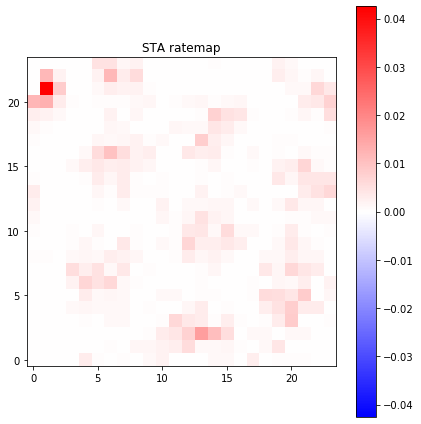

In [4]:
plt.figure(figsize=(6,6))
counts, xbins, ybins, _ = plt.hist2d(pos[pos_spike][:, 0], pos[pos_spike][:, 1], bins=29, 
               cmap='Reds')
plt.close()
X = np.zeros([pos.shape[0], len(xbins), len(ybins)])
for i in range(pos.shape[0]):
    condx = np.where(pos[i][0] < xbins)[0]
    if len(condx) > 0:
        condx = condx[0]
    else:
        condx = len(xbins)-1
        
    condy = np.where(pos[i][1] < ybins)[0]
    if len(condy) > 0:
        condy = condy[0]
    else:
        condy = len(ybins)-1    

#     cond = np.array([condx, condy])
    X[i][condx, condy] = 1

cut = 3
Xdsgn = X[:, cut:-cut, cut:-cut]
# Xdsgn = X
plt.figure(figsize=(6,6))
STA = Xdsgn[pos_spike].mean(0)
plt.imshow(STA.T, cmap=plt.cm.bwr, origin='lower', vmin=-STA.max(), vmax=STA.max())
plt.colorbar()
plt.title('STA ratemap')
plt.tight_layout()
dims = Xdsgn.shape[1:]
Xdsgn = Xdsgn.reshape(Xdsgn.shape[0], np.prod(Xdsgn.shape[1:]))

In [5]:
(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(Xdsgn, y, dt=0.02, frac_train=0.5, frac_dev=0.25)

SUMMARY
               N    Minutes   Fraction
Total      59587      19.86        1.0
Train      29790       9.93        0.5
Dev        14910       4.97       0.25
Test       14887       4.97       0.25


### fit model

In [6]:
dims = [24, 24]

df = [13, 13]
dt = 0.02
m = GLM(distr='poisson', output_nonlinearity='exponential')

# # training set; fit instantaneous RF with `lag=False`
m.add_design_matrix(X_train, lag=False, dims=dims, df=df, smooth='cr', filter_nonlinearity='none', name='stimulus') # light stimulus

# dev set; if training set used spline, dev set will apply the same basis
m.add_design_matrix(X_dev, lag=False, name='stimulus', kind='dev')

# initialize all model parameters
m.initialize(y={'train': y_train, 'dev': y_dev}, num_subunits=1, dt=dt, method='mle', random_seed=2046, add_noise_to_mle=0.)

# fit 
m.fit(y={'train': y_train, 'dev': y_dev}, 
       num_iters=1500, verbose=100, step_size=0.1, beta=.05)



Iters	  Time (s)	Cost (train)	Cost (dev)	corrcoef (train)	corrcoef (dev)
    0	     0.693	 30492.479	 12549.799	     0.040	     0.027
  100	     2.480	  3291.420	  1992.262	     0.184	     0.111
  200	     4.293	  3221.038	  1960.175	     0.218	     0.134
  300	     6.244	  3155.478	  1934.599	     0.223	     0.137
  400	     9.035	  3100.225	  1914.375	     0.224	     0.137
  500	    11.815	  3057.755	  1900.554	     0.224	     0.136
  600	    14.562	  3027.459	  1892.000	     0.225	     0.136
  700	    17.371	  3006.849	  1887.275	     0.225	     0.136
  800	    20.042	  2993.194	  1884.858	     0.225	     0.136
  900	    22.832	  2984.234	  1883.561	     0.226	     0.137
 1000	    25.625	  2978.327	  1883.286	     0.226	     0.137
 1100	    28.278	  2974.381	  1883.361	     0.227	     0.138
Stop at 1125 steps: cost (dev) has been monotonically increasing for 10 steps.
Total time elapsed: 28.955s.



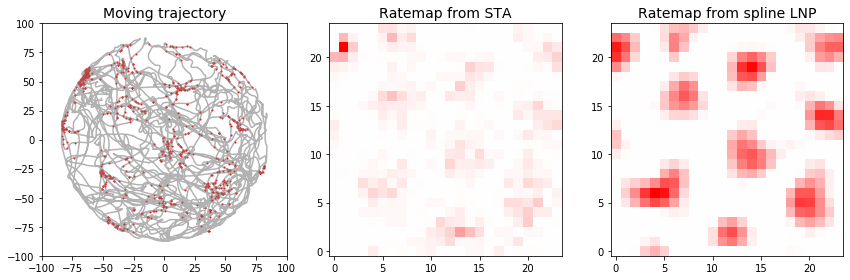

In [7]:
pos_spike_sub = [spike for spike in pos_spike if spike < 29790] # plot traj of the training set only.

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax = ax.flatten()
ax[0].plot(pos[:, 0][:29790], pos[:, 1][:29790], color='gray', alpha=0.6)
ax[0].scatter(pos[pos_spike_sub][:, 0], pos[pos_spike_sub][:, 1], color='red', s=1)
ax[0].set_xlim(-100, 100)
ax[0].set_ylim(-100, 100)
ax[0].set_title('Moving trajectory', fontsize=14)

vmax = np.max([np.abs(STA.min()), np.abs(STA.max())])
ax[1].imshow(np.maximum(0, STA.T), 
           cmap=plt.cm.bwr, origin='lower', vmin=-vmax, vmax=vmax)
ax[1].set_title('Ratemap from STA', fontsize=14)
fig.tight_layout()

spline_ratemap = m.w['opt']['stimulus'].reshape(dims).T
vmax = np.max([np.abs(spline_ratemap.min()), np.abs(spline_ratemap.max())])

ax[2].imshow(np.maximum(0, spline_ratemap), 
           cmap=plt.cm.bwr, origin='lower', vmin=-vmax, vmax=vmax)
ax[2].set_title('Ratemap from spline LNP', fontsize=14)
fig.tight_layout()